# Lab on basics in image processing

# Table of Contents
* [Lab on basic image processing](#Lab-on-basic-image-processing)
	* [Introduction](#Introduction)
	* [Frequency representation -- Filtering in the frequency domain](#Frequency-representation----Filtering-in-the-frequency-domain)
		* [A pretty sine wave](#A-pretty-sine-wave)
	* [Playing with Barbara -- Filtering in the frequency domain](#Playing-with-Barbara----Filtering-in-the-frequency-domain)
	* [Filtering by convolution](#Filtering-by-convolution)


## Introduction

The objective of this lab is to show how the notions we discovered in the monodimensional case -- that is for signals, can be extended to the two dimensional case. This also enable to have a new look at these notions and perhaps contribute to stenghten their understanding. 

In particular, we will look at the problems of representation and filtering, both in the direct (spatial) domain and in the transformed (spatial frequencies) domain. Next  we will look at the problems of sampling and  filtering.  

Within Python, the modules `scipy.signal` and `scipy.ndimage` will be useful. 


In order to facilitate your learning and work, your servant has prepared a bunch of useful functions, namely: 

    rect2 -- returns a two dimensional centered rectangle
    bandpass2d -- returns a 2D-bandpass filter (in the frequency domain)
    showfft2 -- display of the 2D-Fourier transform, correcly centered and normalized
    mesh -- display a ``3D'' representaion of an objet (à la Matlab (tm))

To read an image file, you will use the function `imread`. 

To display an image in gray levels, you may use

```python
        imshow(S,cmap='gray',origin='upper')
```

You may either display your graphics inline (it is the default below) or using external windows; for that call `%matplotlib`. To return to the inline mode,  use 
`%matplotlib inline`. 


In [1]:
#This was for Python v. 2.7
#from __future__ import division
#from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from numpy import abs, where, sin, cos, ones, zeros, log, pi
from scipy import ndimage as ndi
from scipy import signal as sig
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
from scipy.ndimage import convolve as convolvend
# For 3D representations
from mpl_toolkits.mplot3d.axes3d import Axes3D

# change the dpi for a better vizualisation of images
import matplotlib
savedpi=matplotlib.rcParams['savefig.dpi']
%matplotlib inline

Listing of offered utility functions

In [2]:
# from defs_tp_img import *
# 
## Definitions
# ============

def isodd(num):
        return num & 1 and True or False
# or num%2==1        

## 
def rect2(L,N):
    """ Returns a (2L+1)x(2L+1) rectangle centered over a 
    NxN matrix"""
    x=np.zeros((N,N))
    center=(round((N+1)/2),round((N+1)/2)) if isodd(N) else (round(N/2+1),round(N/2+1))
    x[center[0]-L:center[0]+L+1,center[1]-L:center[1]+L+1]=1    
    return x

## 
def bandpass2d(position,half_width,total_dim):    
    """ Returns the frequency response of a bandpass filter, correctly centered on
    `position`, of half-width `half_width` and symmeterized in frequency domain 
    (zero at the center of the resulting matrix)
    Parameters
    ----------
    position: array
        center-frequency of the band-pass response 
        (in samples -- the corresponding frequencies are 2*position/total_dim)
    half_width: integer
         half frequency band
    total_dim: integer
          image dimension
    Author : jfb"""
    N=total_dim    
    center=(round((N+1)/2),round((N+1)/2)) if isodd(N) else (round(N/2+1),round(N/2+1))
    # 
    H=zeros((N,N))    
    H[center[0]+position[0]-half_width:center[0]+position[0]+half_width+1,center[1]+position[1]-half_width:center[1]+position[1]+half_width+1]=1    
    position=-np.array(position)  # symmetric frequencies
    H[center[0]+position[0]-half_width:center[0]+position[0]+half_width+1,center[1]+position[1]-half_width:center[1]+position[1]+half_width+1]=1    
    return H
    
## 2D fequency representation
def showfft2(X,Zero='uncentered', Freq='normalized', num=None,cmap='hot'):
    """Display an image, in the 2D Fourier domain
    The representation is centered and in normalized frequencies.
    **/!\\   *showfft2* **does not compute the Fourier transform**. 
    The user is responsible for supplying correct data.
    Parameters:
    -----------
        X : 2D data in the Fourier domain
        Num: Figure number(optional)
        Zero='uncentered' (default), the input Fourier transform are supposed uncenterd and a 
        fftshift is applied
        Freq='normalized' (default); otherwise axis are in samples
    ``Author: jfb``
    """
    N,M=np.shape(X)
    plt.figure(num)
    if Zero!='centered':
        X=fftshift(X)
    if Freq=='normalized':
        extent=(-0.5, 0.5, -0.5, 0.5)
    else:
        extent=(-N/2, N/2, -N/2, N/2)
    im=plt.imshow(X,aspect='auto',origin='lower', extent=extent, cmap=cmap)    
    if Freq=='normalized':   
        ticks=np.arange(-0.5,0.6,0.1)
        plt.xticks(ticks)
        plt.yticks(ticks)
    plt.colorbar()
  

   
def mesh(obj3D,numfig=None,subplt=(1,1,1),cmap='hot'):
    """
    Emulates Matlab's mesh 
    Author: jfb
    """
    fig = plt.figure(numfig)
    ax = fig.add_subplot(subplt[0],subplt[1],subplt[2], projection='3d')
    m,n=np.shape(obj3D)
    mm=np.arange(m)
    nn=np.arange(n)
    X,Y=np.meshgrid(nn,mm)
    ax.plot_surface(X, Y, obj3D, rstride=max([round(m/50), 1]), 
                    cstride=max([round(n/50), 1]), cmap=cmap)
    
def saltpepper(percent=85,shape=None):
        s=np.random.random(size=shape)
        d=np.where(s>percent/100)
        out=np.ones(shape=shape)
        out[d]=0
        return out


## Frequency representation -- Filtering in the frequency domain

### A pretty sine wave

- Generate a sine wave $f(x,y) = \sin(2\pi (f_x x+f_y y))$ , with $f_x$ an $f_y$ between 0.02 à 0.2, on $N\times N$ points (e.g.  $N=512$). For the implementation, you may use a `for` loop, or a double comprehension list, or even the smart function `fromfunction()` and an anonymous `lambda` function.  Display the result using  `imshow`.

Note that for a matrix, usually the first index denotes the rows and the second the columns. Therefore modifying something with respect to x results in a variation along the rows of the matrix (usually the "y" axis)..

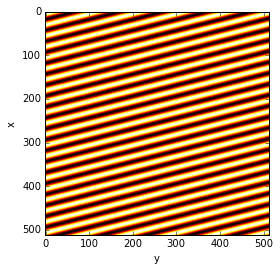

In [3]:
fx,fy= 0.04, 0.01

x=np.arange(512)
y=np.arange(512)
# using a double comprehension list
S=[[sin(2*pi*(fx*xx+fy*yy)) for xx in x] for yy in y]  
# of the fromfunction
Z=np.fromfunction(lambda x,y: sin(2*pi*(fx*x+fy*y)),(512,512))
# Display
plt.imshow(Z,cmap='hot',origin='upper')
_=plt.xlabel('y')
_=plt.ylabel('x')

- Transform your program into a function `pltsin` which takes the two frequencies as inputs. Then implement a interactive version, using the lines
```python
from IPython.html.widgets import interact, interactive, fixed
interact(pltsin,fx=[-0.1,0.1,0.01], fy=[-0.1,0.1,0.01])  
```
Then play with the parameters, and look at what happens when you change the values of the frequencies. 

<function __main__.pltsin>

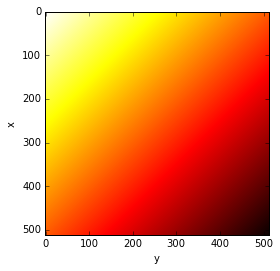

In [4]:
#from IPython.html.widgets import interact, interactive, fixed
from ipywidgets import interact, interactive, fixed
def pltsin(fx,fy):
    Z=np.fromfunction(lambda x,y: sin(2*pi*(fx*x+fy*y)),(512,512))
    plt.imshow(Z,cmap='hot',origin='upper')
    _=plt.xlabel('y'), plt.ylabel('x')
interact(pltsin,fx=[-0.1,0.1,0.01], fy=[-0.1,0.1,0.01])   

- Compute the 2D Fourier transform of $f(x,y)$ (using function fft2) and display the modulus (function abs) of the result, via `showfft2`. What are the significations of the axes? What are the spatial frequencies of the sine wave. Experiment with several values of $f_x, f_y$. 

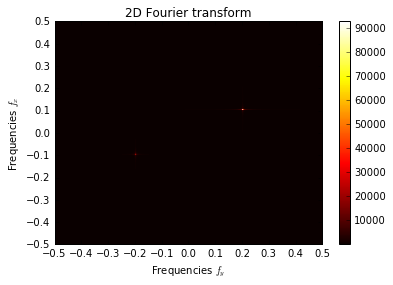

In [5]:
# We change the frequenies for ease of visualization in the frequency domain
fx,fy= 0.1, 0.2
S=np.fromfunction(lambda x,y: sin(2*pi*(fx*x+fy*y)),(512,512))

# Display
showfft2(abs(fft2(S)),num=4) 
plt.title('2D Fourier transform')   
plt.xlabel('Frequencies $f_y$')
_=plt.ylabel('Frequencies $f_x$')

- Show theoretically, and then check it numerically, that the 2D Fourier transform can be obtained as the succession of two 1-dimensional transforms, applied respectively to the rows and then to the columns (or vice versa).  You will take advantage of the fact that the standard `fft` has a parameter axis which is the axis over which the `fft` is actually computed. 

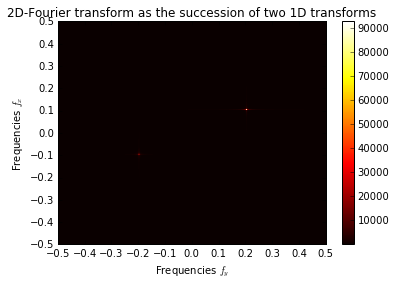

In [6]:
# Correction
showfft2(abs(fft(fft(S,axis=0),axis=1)),num=5)
plt.title('2D-Fourier transform as the succession of two 1D transforms')   
plt.xlabel('Frequencies $f_y$')
_=plt.ylabel('Frequencies $f_x$')


## Playing with Barbara -- Filtering in the frequency domain

*Rappelle-toi Barbara <br>
Il pleuvait sans cesse sur Brest ce jour-là <br>
Et tu marchais souriante <br>
Épanouie ravie ruisselante <br>
Sous la pluie* (Prévert, 1946)

- Load the image Barbara, using `plt.imread('barbara.png')` and display it (in gray levels).

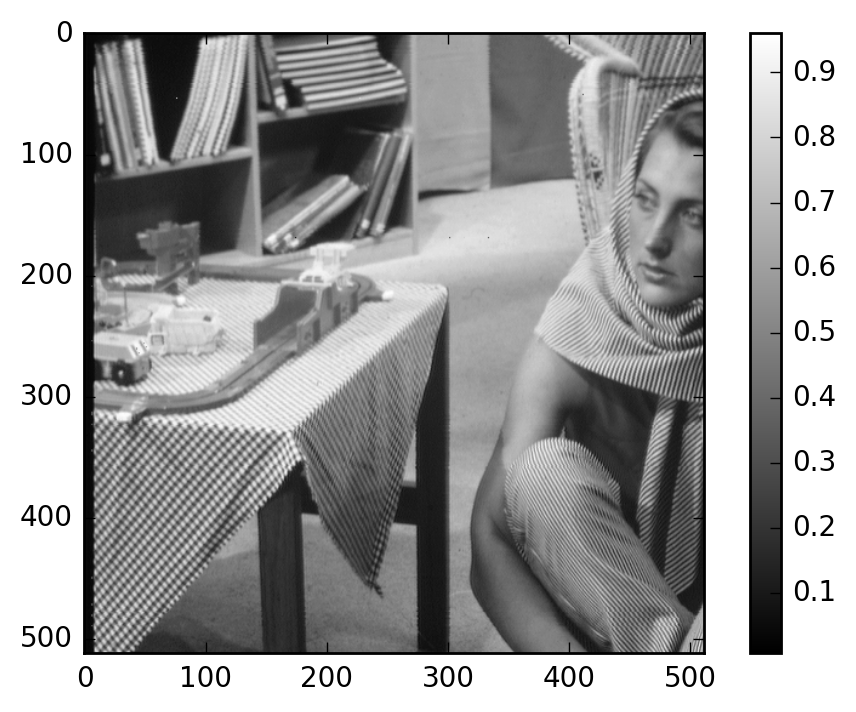

In [7]:
matplotlib.rcParams['savefig.dpi'] = 2*savedpi # double dpi

#%% reading and displaying the image
B=plt.imread('barbara.png')
plt.figure(1)
plt.imshow(B,cmap='gray',origin='upper')
_=plt.colorbar()


-  Display the corresponding frequency representation `showfft2` , in log scale (simply take `log(abs())`!) 

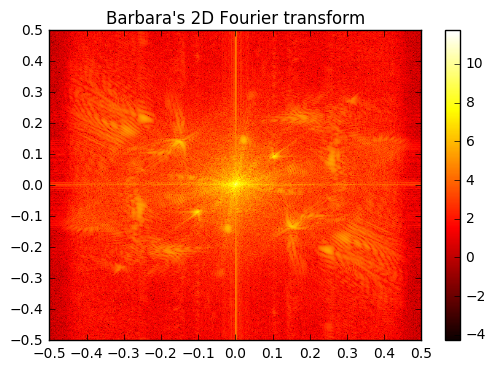

In [8]:
matplotlib.rcParams['savefig.dpi'] = savedpi #restore dpi
showfft2(log(abs(fft2(B))))
_=plt.title("Barbara's 2D Fourier transform")

- Filter this image using a low-pass filter with a rectangular frequency response (use the function `rect2`), for rectangles of half-width 40, 80 ,100. Display the different resulting images, as well as the differences with the initial image. Observations, conclusions. 

In [9]:
L=100
H=rect2(L,512)
 





/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


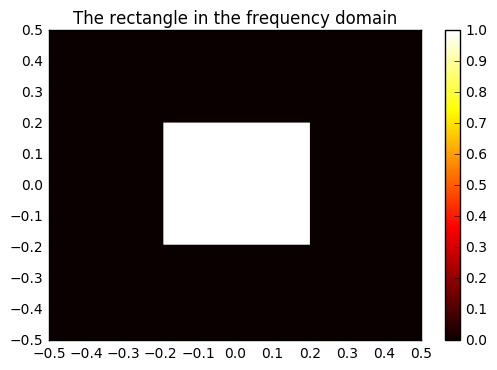

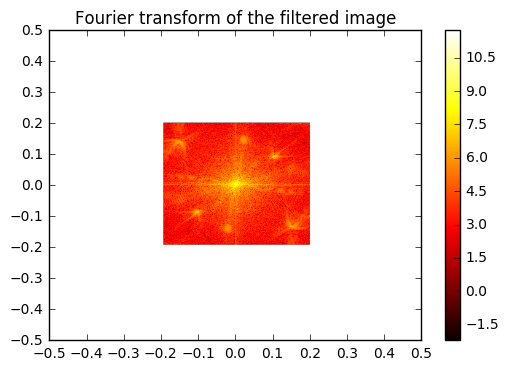

In [10]:
L=100
H=rect2(L,512)
showfft2(H,Zero='centered') ## !    
plt.title('The rectangle in the frequency domain')
# Filtering
Bf_filtered=fft2(B)*fftshift(H)
showfft2(log(abs(Bf_filtered)))
plt.title('Fourier transform of the filtered image')

The corresponding results in the spatial domain are:

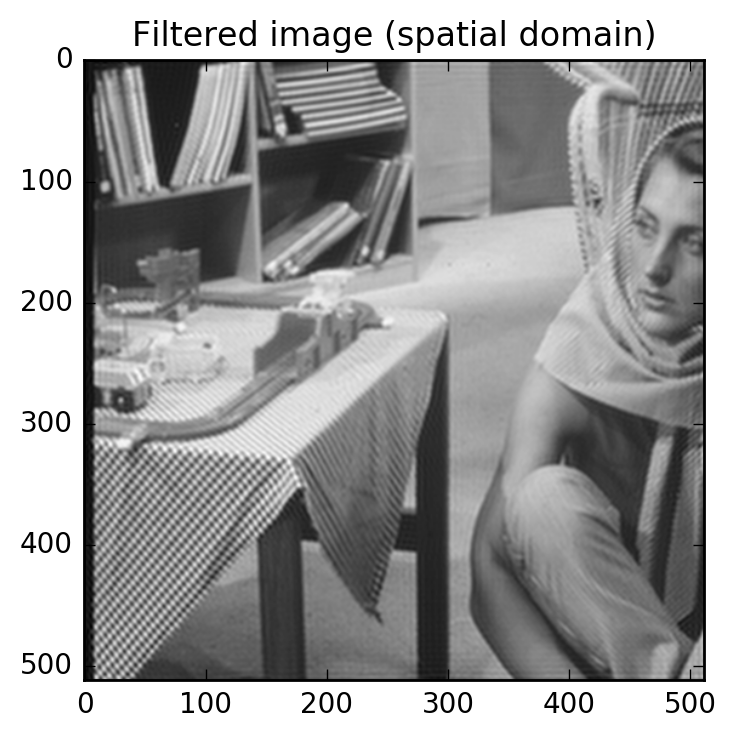

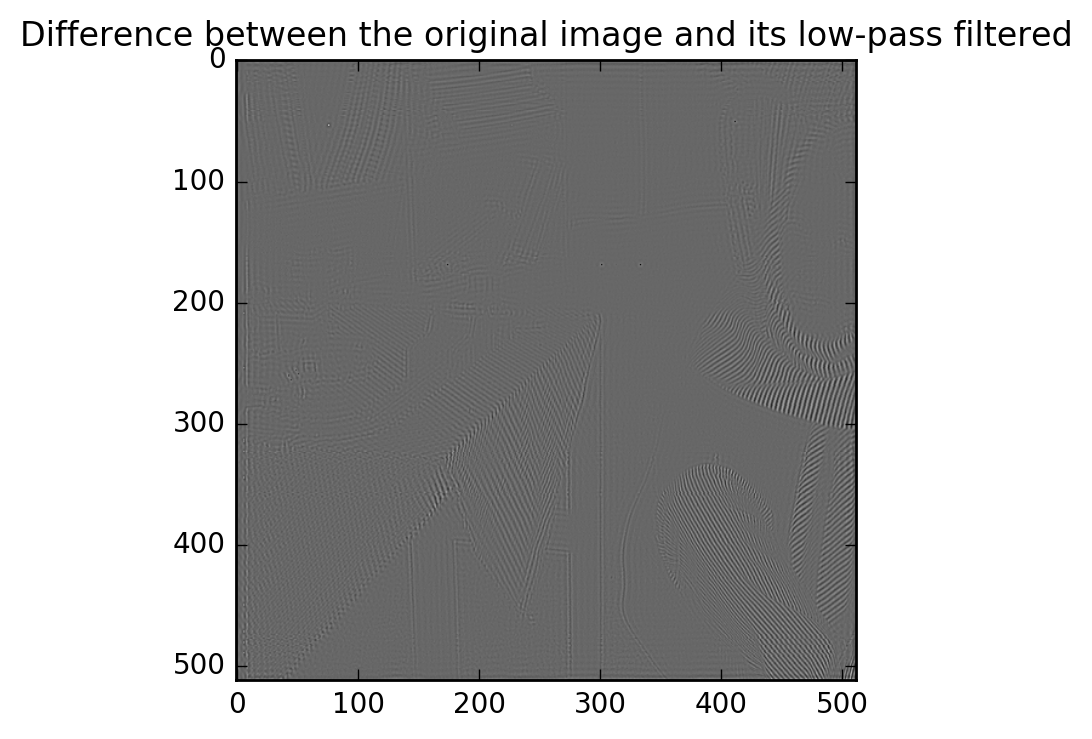

In [11]:
matplotlib.rcParams['savefig.dpi'] = 2*savedpi 
#And in the spatial domain
plt.imshow(np.real(ifft2(Bf_filtered)),cmap='gray',origin='upper')
plt.title("Filtered image (spatial domain)")
# Also experiment with L=80, L=100
# Differences : 
plt.figure()
plt.imshow(B-np.real(ifft2(Bf_filtered)),cmap='gray',origin='upper')
_=plt.title("Difference between the original image and its low-pass filtered")

What appear in the difference image are indeed the "high frequencies", which are the "details" of the original image (Actually, by computing the difference with the low-pass filtered, we have implemented an high-pass filter...) 

- design a frequency response that kills selectively the frequencies around points (46,54) and (-70,79), e.g. on a neighborhood of  $\pm$ 10 points. In order to do that, you may use the function `bandpass2d`, and you will create a frequency rejector by  `1-bandpass2d`. Look again at the Fourier transform of Barbara, but wit the axes in  points, so as to understand what you do. Apply the filter to the initial image and look at the result in the spatial domain. Try to understand the modifications. In particular, **look at the tablecloth**. Also look at the difference image. 

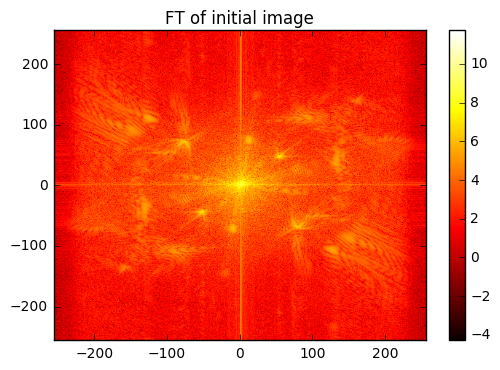

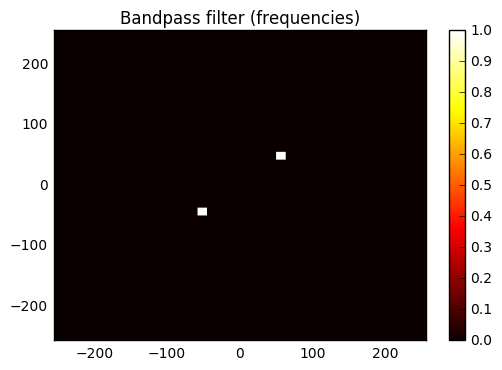

In [12]:
matplotlib.rcParams['savefig.dpi'] = savedpi  # restore initial dpi
# Rejector filter
B=plt.imread('barbara.png');
Bf=fft2(B)
showfft2(log(abs(Bf)),Zero='uncentered',Freq='unnorm') ## !  
plt.title("FT of initial image")
## figure(3)
X=bandpass2d((46,54),6,512) 
# beware ; when adressing an array A(x,y), the "x" are the rows 
# (1st index) eand the  "y" the columns, therefore we have to exchange the two indexes.

showfft2(X,Zero='centered',Freq='unnorm') 
plt.title('Bandpass filter (frequencies)')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


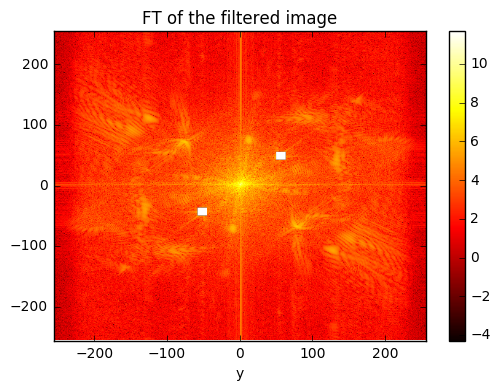

In [13]:
matplotlib.rcParams['savefig.dpi'] = savedpi
X=bandpass2d((46,54),6,512) 
## figure(4)
X=1-X #rejector
Bf_filtered=X*fftshift(Bf)
showfft2(log(abs(Bf_filtered)),Zero='centered',Freq='unnorm') ## !  
plt.title("FT of the filtered image")
plt.xlabel('y')

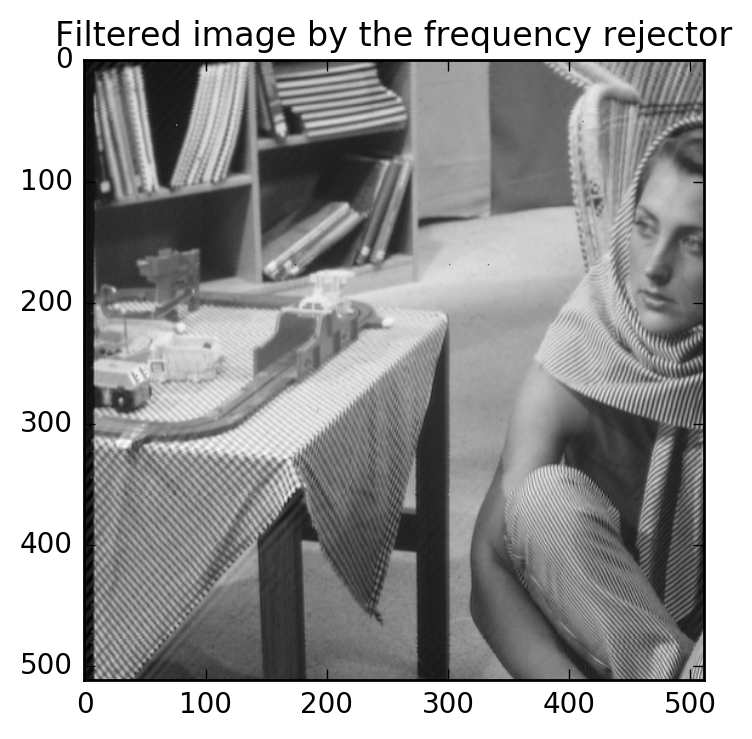

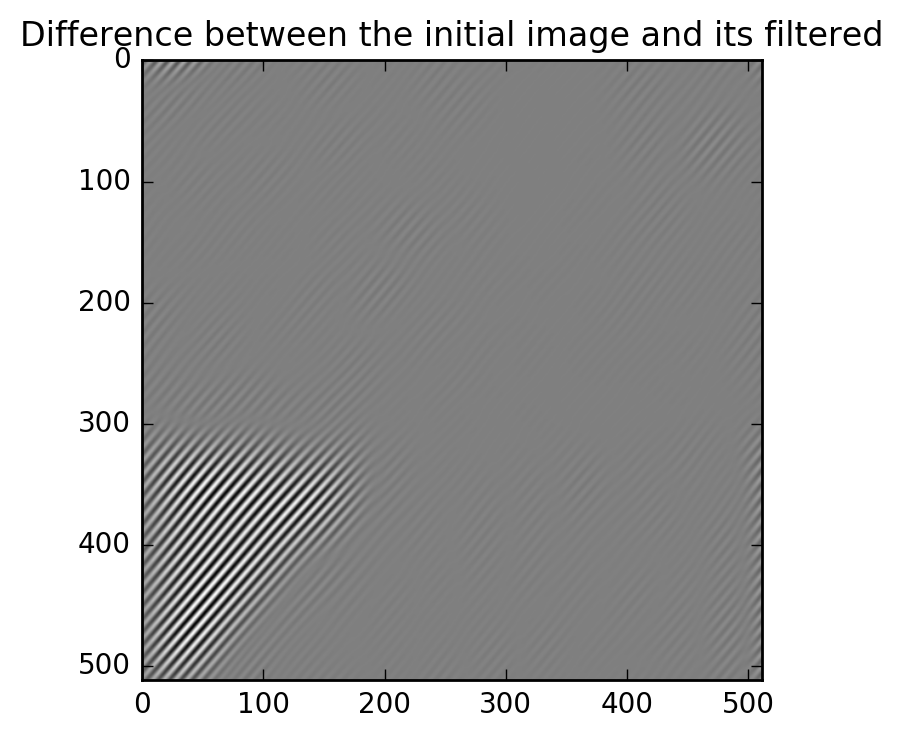

In [14]:
# in the spatial domain we than have
matplotlib.rcParams['savefig.dpi'] = 2*savedpi 
B_filtered=np.real(ifft2(fftshift(Bf_filtered)))
plt.figure()
plt.imshow(B_filtered,cmap='gray',origin='upper')
plt.title("Filtered image by the frequency rejector")
# Differences: 
plt.figure()
plt.imshow(B-B_filtered,cmap='gray',origin='upper')
plt.title("Difference between the initial image and its filtered")

*Look at the tablecloth!*

## Filtering by convolution

The function that will be useful in this part is the function `convolve` from the module scipy.ndimage (get it by `ndi.convolve` if ndimage has been imported under the name ndi). We will alo use a `np.random.normal(size=(...))` for adding gaussian noise (with typically a scale 0.1); or `saltpepper` for a salt and pepper noise. 


- begin by implementing a convolution in two dimensions, by studying the following code:

        h=ones((2*ll+1,2*ll+1)) # h the impulse response
        for m in range(ll,M-ll):
            for n in range(ll,N-ll):
                B_filtered[m,n]=sum(sum(h*B[m-ll:m+ll+1,n-ll:n+ll+1]))      

Compute a low-pass filtering of Barbara (h constant over an half width of 3 to 10), and examine the result. 

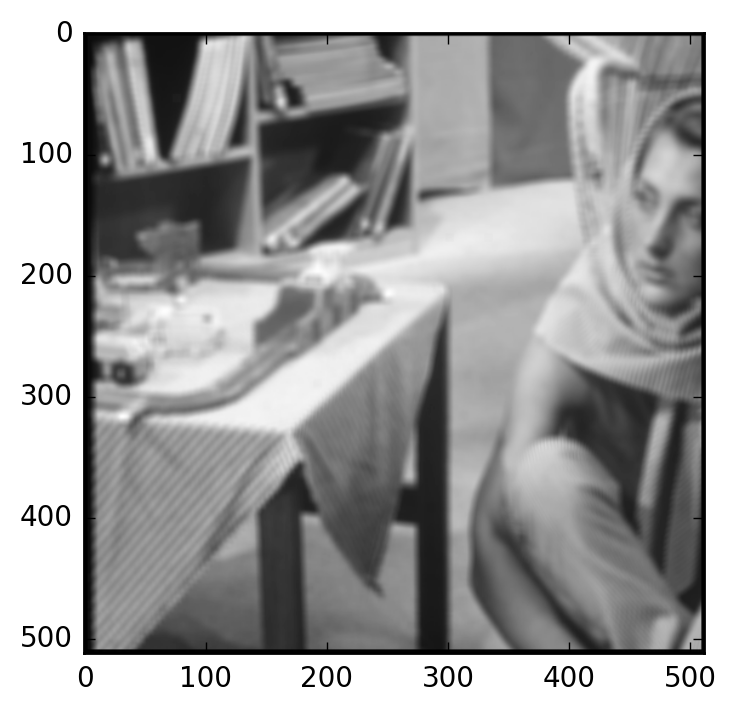

In [15]:
(N,M)=np.shape(B)
ll=3
h=ones((2*ll+1,2*ll+1)) # the impulse response
for m in range(ll,M-ll):
    for n in range(ll,N-ll):
        B_filtered[m,n]=sum(sum(h*B[m-ll:m+ll+1,n-ll:n+ll+1]))
       
plt.figure(9)
plt.imshow(B_filtered,cmap='gray',origin='upper')      


As we see, it is very simple. Nothing but a sum of products.  A better implementation would take care of edge effects. 

- Do this filtering again, but using the function `ndi.convolve`. Examine the effect of the filtering with an additive gaussian noise `np.random.normal(size=(512,512)` with scale 0.1 or a salt and pepper noise. Check that the filtering is indeed a low-pass filter by looking at its transfer function -- use a zero-padding when computing the Fourier transform `fft2(h,s=(1000,1000))`. You can also use the `mesh` function for the representation.

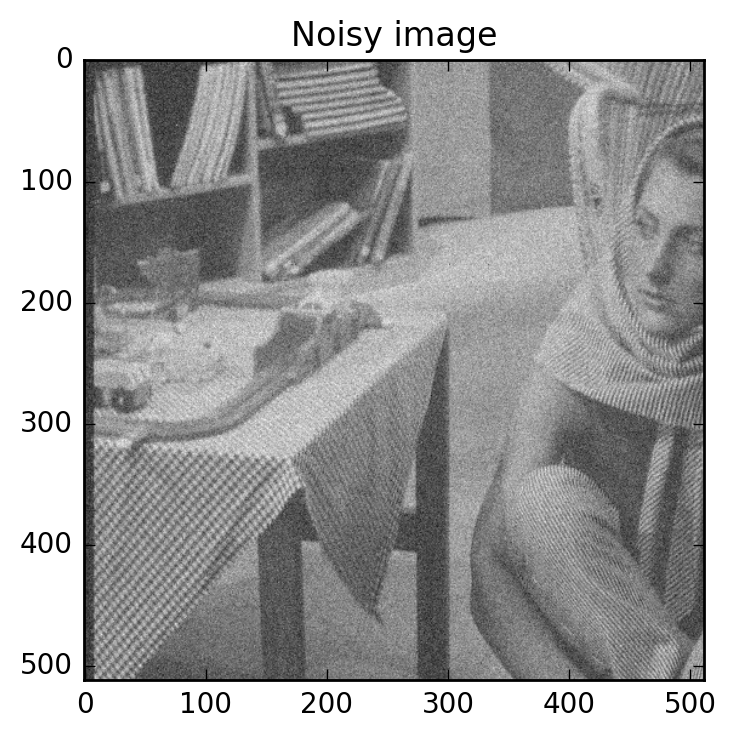

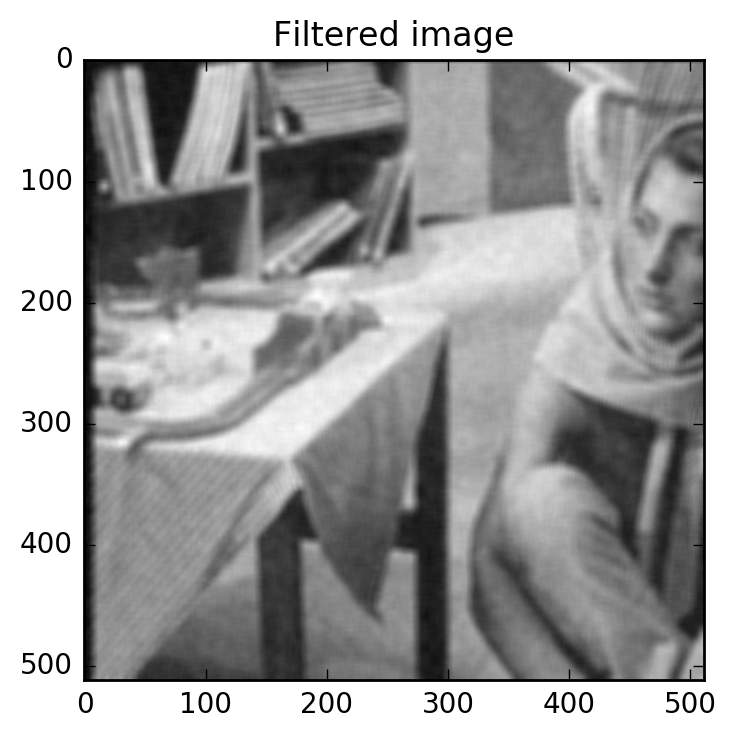

In [16]:
B=plt.imread('barbara.png')
L=8
h=ones((L,L)) # the IR
B=B+0.1*np.random.normal(size=(512,512))
#B=B+0.5*saltpepper(percent=98, shape=np.shape(B))
plt.figure(9)
plt.imshow(B,cmap='gray',origin='upper')
plt.title('Noisy image')
B_filtered=ndi.convolve(B,h)
plt.figure(10)
plt.imshow(B_filtered,cmap='gray',origin='upper')   
plt.title('Filtered image')


Transfer function

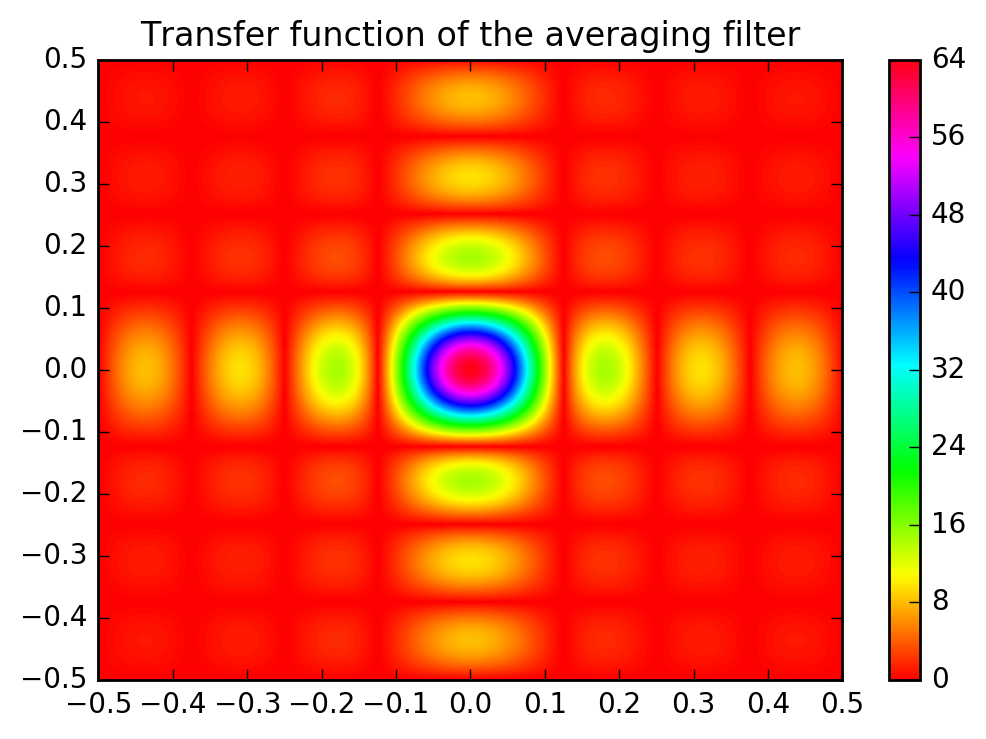

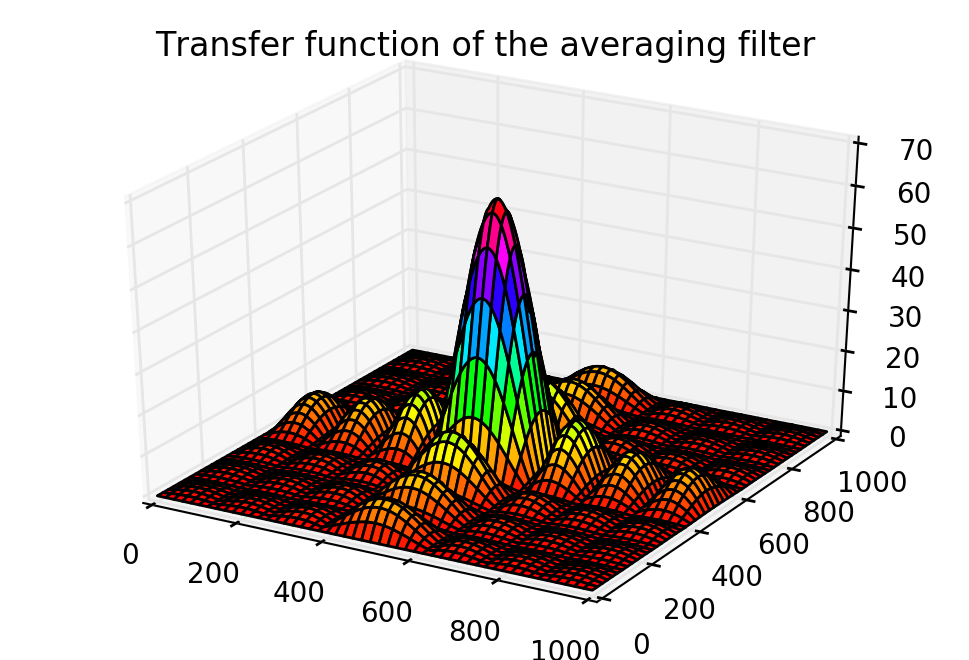

In [17]:

# Lets us look at the transfer function associated with this impulse response.. 
H=fft2(h,s=(1000,1000))
showfft2((abs(H)),Zero='uncentered',Freq='normalized', num=11, cmap='hsv') ## !  
plt.title('Transfer function of the averaging filter')
#
mesh(abs(fftshift(H)),numfig=12, cmap='hsv')
plt.title('Transfer function of the averaging filter')


Conclusion: it is indeed a low-pass!

- On the Barbara image, or on the image of cells, or of bacterias, test a Prewit or a Sobel gradient, with impulse responses

         dx=np.array([[1.0, 0.0, -1.0],[1.0, 0.0, -1.0],[1.0, 0.0, -1.0],])      
         # dx=np.array([[1.0, 0.0, -1.0],[2.0, 0.0, -2.0],[1.0, 0.0, -1.0],]) #Sobel
         dy=np.transpose(dx)
  
applied over the two directions (x,y), by `ndi.convolve` and build the gradient magnitude image. 

NB: if Dx and Dy are the gradient images obtained in directions x, y, then the gradient magnitude image is  $\sqrt{Dx^2+Dy^2}$.

The ndimage module contains many predefined filters, such as  `scipy.ndimage.filters.sobel`. However, we use here the direct convolution, for pedagogical purposes, instead of these functions. 


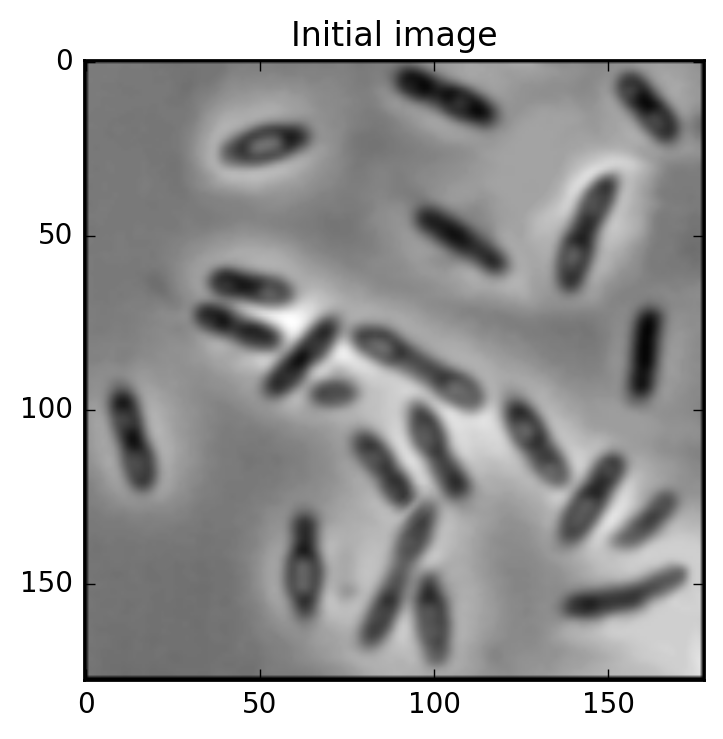

In [18]:
# Computation of gradient images and magnitude image
B=plt.imread('bacteria.png') # ou cellules.png
plt.figure()
plt.imshow(B,cmap='gray',origin='upper')
plt.title('Initial image') 
# Sobel Filter
dx=np.array([[1.0, 0.0, -1.0],[2.0, 0.0, -2.0],[1.0, 0.0, -1.0],])
dy=np.transpose(dx)
fo1=ndi.convolve(B,dx, output=np.float64, mode='nearest')
fo2=ndi.convolve(B,dy, output=np.float64, mode='nearest')
magnitude=np.sqrt(fo1**2+fo2**2)

### Prewitt Filter
#dx=np.array([[1.0, 0.0, -1.0],[1.0, 0.0, -1.0],[1.0, 0.0, -1.0],])
#dy=np.transpose(dx)

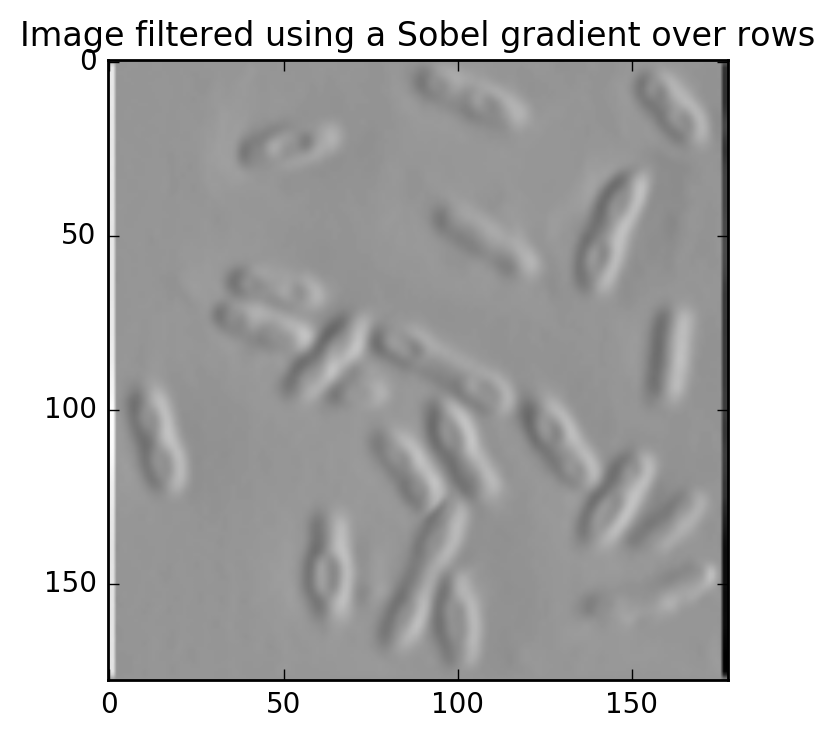

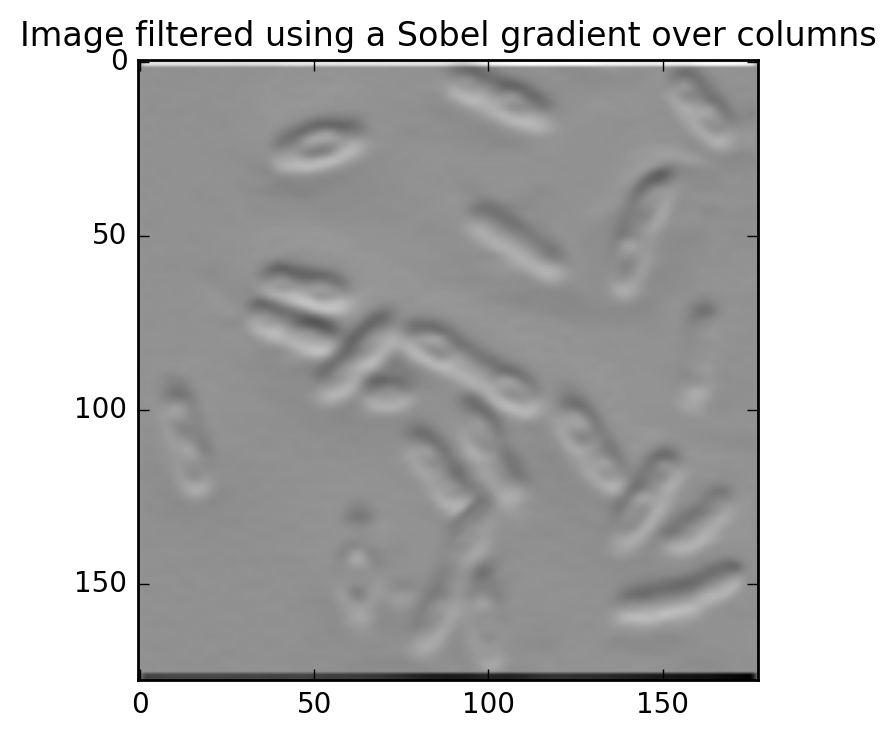

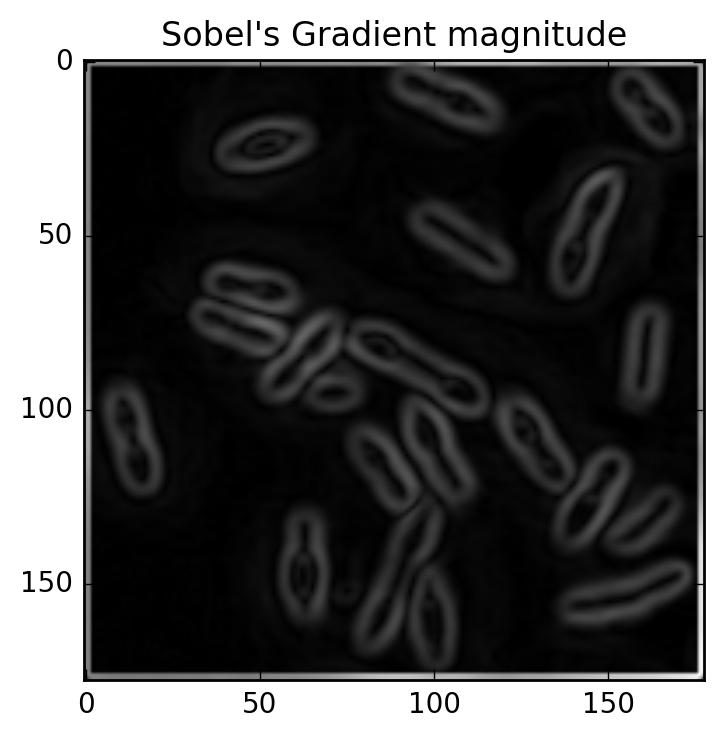

In [19]:
plt.figure()
plt.imshow(fo1,cmap='gray',origin='upper')
plt.title('Image filtered using a Sobel gradient over rows') 
plt.figure()
plt.imshow(fo2,cmap='gray',origin='upper')
plt.title('Image filtered using a Sobel gradient over columns') 
plt.figure()
plt.imshow(magnitude,cmap='gray',origin='upper')
plt.title("Sobel's Gradient magnitude") 

Let us transform this into a black and white image: 

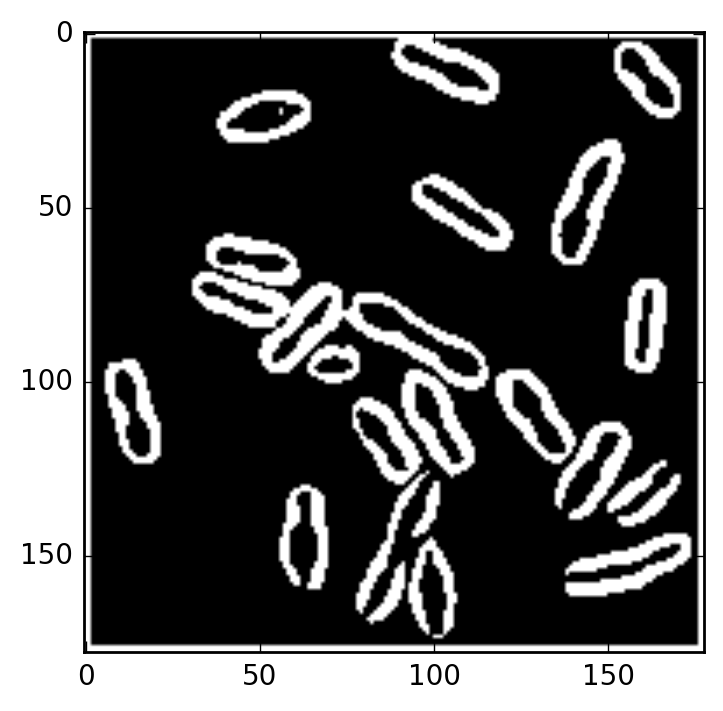

In [20]:
magnitude=magnitude/np.max(magnitude)
X=np.zeros(np.shape(magnitude))
X[magnitude>0.15]=100
plt.imshow(X, cmap='gray')

Sobel's transfer function

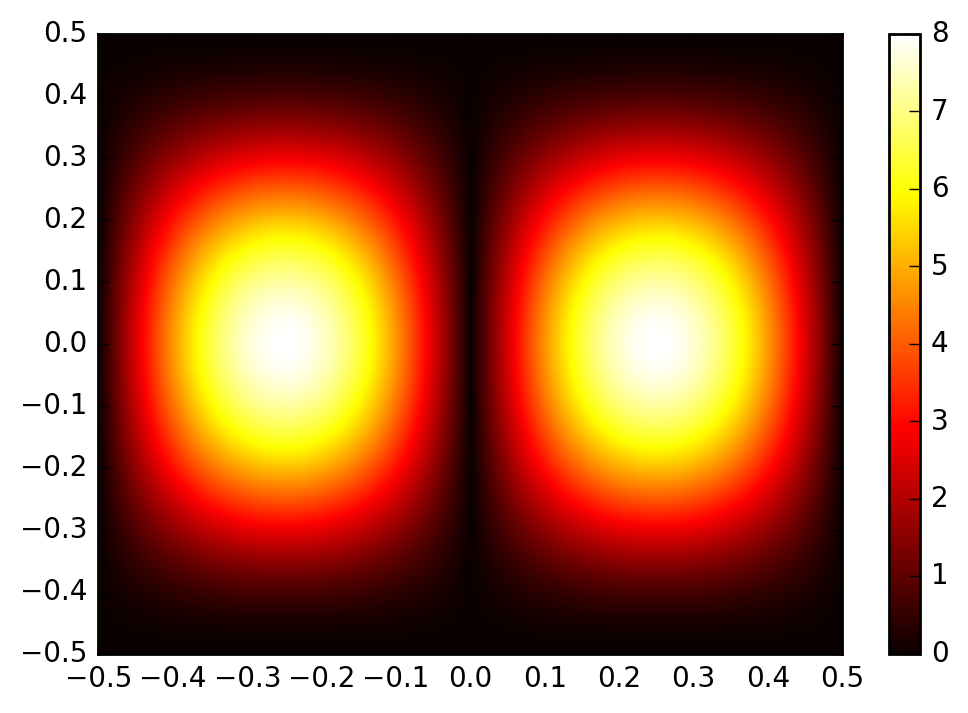

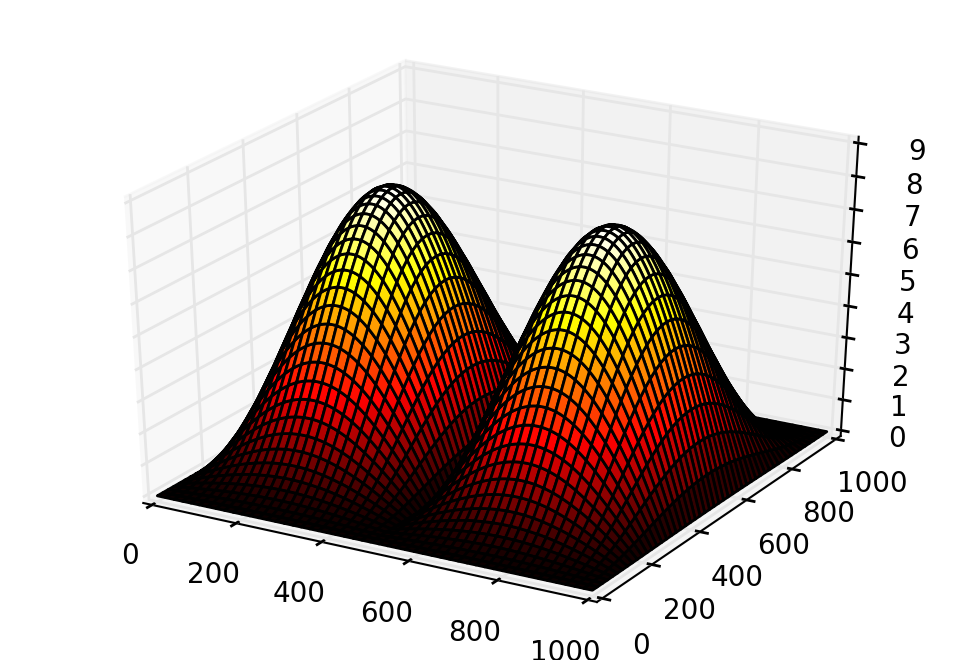

In [21]:
# Sobel's transfer function
Dx=fft2(dx,s=(1000,1000))
showfft2((abs(Dx)),Zero='uncentered',Freq='normalized') ## ! 
# or mesh(abs(fftshift(Dx)))
mesh(abs(fftshift(Dx)))
# It is indeed an high-pass filter!

Idem with Barbara

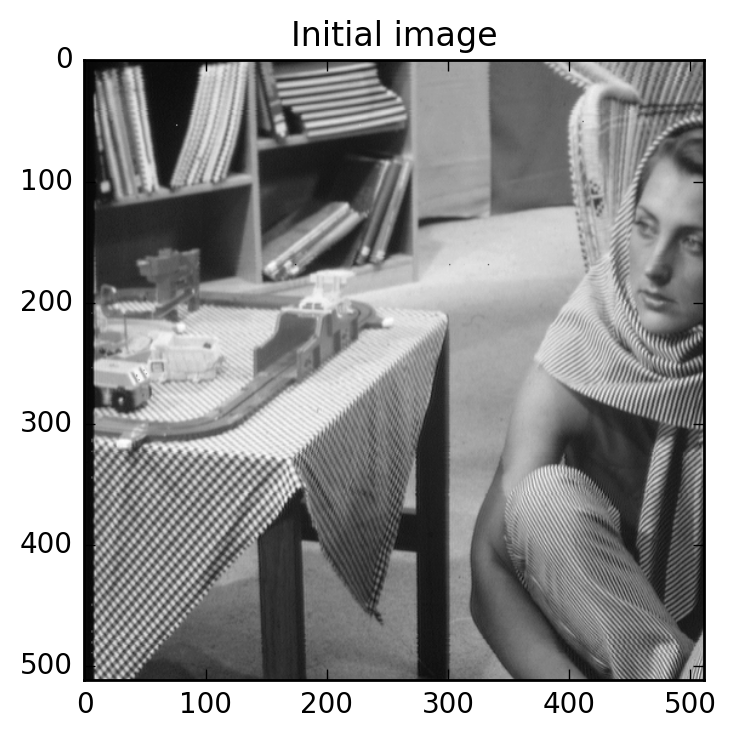

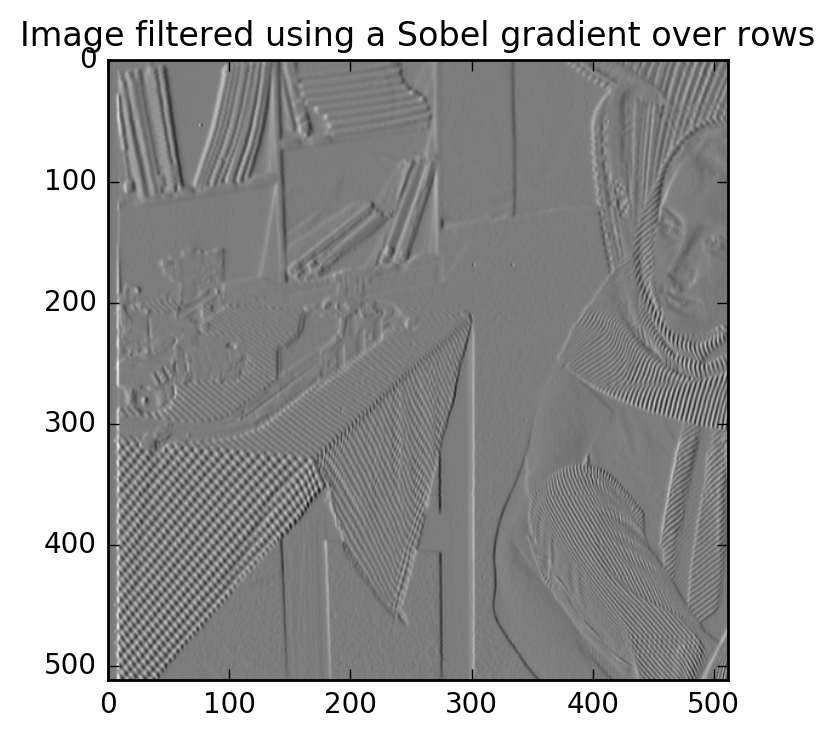

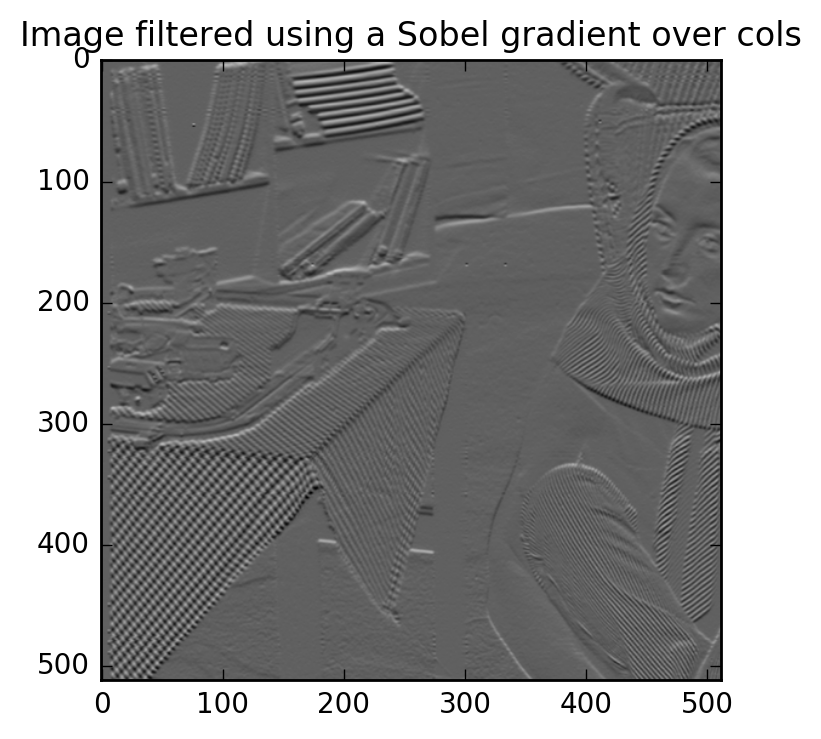

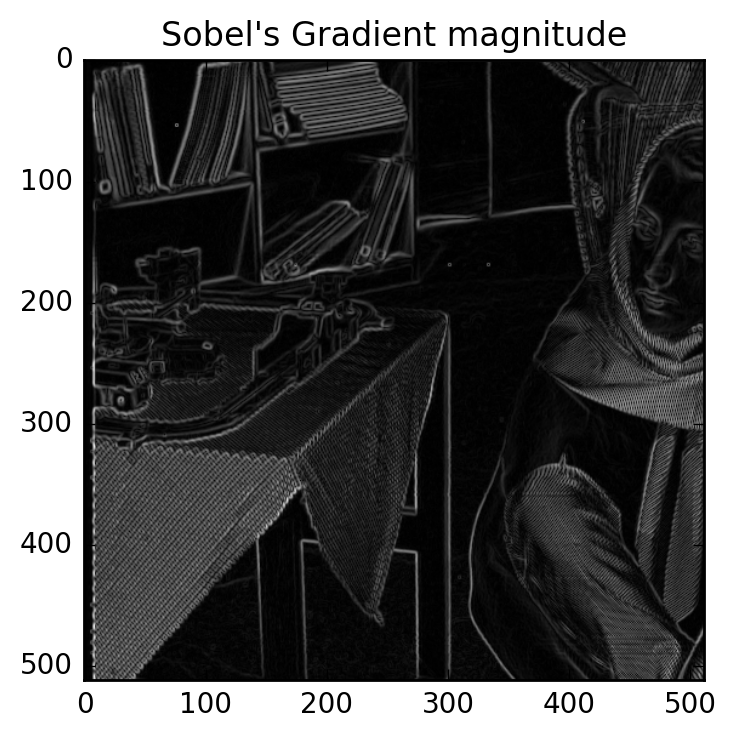

In [22]:
B=plt.imread('barbara.png') # ou cellules.png
plt.figure()
plt.imshow(B,cmap='gray',origin='upper')
plt.title('Initial image') 
# Sobel Filter
dx=np.array([[1.0, 0.0, -1.0],[2.0, 0.0, -2.0],[1.0, 0.0, -1.0],])
dy=np.transpose(dx)
fo1=ndi.convolve(B,dx, output=np.float64, mode='nearest')
fo2=ndi.convolve(B,dy, output=np.float64, mode='nearest')
magnitude=np.sqrt(fo1**2+fo2**2)
#
plt.figure()
plt.imshow(fo1,cmap='gray',origin='upper')
plt.title('Image filtered using a Sobel gradient over rows') 
plt.figure()
plt.imshow(fo2,cmap='gray',origin='upper')
plt.title('Image filtered using a Sobel gradient over cols') 
plt.figure()
plt.imshow(magnitude,cmap='gray',origin='upper')
plt.title("Sobel's Gradient magnitude") 

----
<div align=right> [Index](toc.ipynb) - [Back](LabImages_text.ipynb) - [Next](DigitalFilters.ipynb)</div>